# Clustering Using Scikit-learn

We're going to continue to investigate some of the functionality provided by scikit-learn (sklearn) for doing machine learning, and specifically in this exercise, clustering.  As before, we will use the World Happiness Report (WHR) data for this exercise, in order to see to what extent we can group different countries together (into clusters) based solely on the indicator values contained in the WHR dataset.

### Step 1.

Execute the code cell below to import some modules and read in and preprocess the WHR data as we have done previously in the classification exercise. We've condensed several groups of previous operations into the code cell below, producing both a dataframe containing the raw numerical data (named ```df2```) and a second dataframe containing the scaled numerical data (named ```X_scaled```), in which scaling has been done to normalize each column to have zero mean and unit standard deviation.

The last line in the code cell below returns the head of the ```df2``` dataframe, to remind you what is in that dataset, and the subsequent code cell (which you should also execute) returns the head of the ```X_scaled``` dataframe.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

dfraw = pd.read_excel('WHR2018Chapter2OnlineData.xls', sheet_name='Table2.1')
cols_to_include = ['country', 'year', 'Life Ladder', 
                   'Positive affect','Negative affect',
                   'Log GDP per capita', 'Social support',
                   'Healthy life expectancy at birth', 
                   'Freedom to make life choices', 
                   'Generosity', 'Perceptions of corruption']
renaming = {'Life Ladder': 'Happiness', 
            'Log GDP per capita': 'LogGDP', 
            'Social support': 'Support', 
            'Healthy life expectancy at birth': 'Life', 
            'Freedom to make life choices': 'Freedom', 
            'Perceptions of corruption': 'Corruption', 
            'Positive affect': 'Positive', 
            'Negative affect': 'Negative'}
df = dfraw[cols_to_include].rename(renaming, axis=1)
key_vars = ['Happiness', 'LogGDP', 'Support', 'Life', 'Freedom', 'Generosity', 'Corruption', 'Positive', 'Negative']

# read in data from SupportingFactors worksheet into a new dataframe dfsupp
dfsupp = pd.read_excel('WHR2018Chapter2OnlineData.xls', sheet_name='SupportingFactors')

# extract out region information from SupportingFactors dataframe
regions = dfsupp[['country', 'Region indicator']].rename({'Region indicator': 'region'}, axis=1)

# compute the mean values of all the WHR data for each country, averaging over all years in the dataset
dfmean = df.groupby('country').mean().drop('year', axis=1)

# merge the mean WHR data with the region information extracted previously
df2 = pd.merge(dfmean, regions, on='country').dropna()

# set the index of df2 to be the country name
df2.set_index('country', inplace=True)

# import the StandardScaler
from sklearn.preprocessing import StandardScaler

# extract out the numerical data and scale it to zero mean and unit standard deviation
X = df2[key_vars]
scaler = StandardScaler().fit(X)
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns = X.columns, index = X.index)


# examine the df2 dataframe -- mean WHR values for each country, along with associated regions
df2.head()

,Happiness,Positive,Negative,LogGDP,Support,Life,Freedom,Generosity,Corruption,region
country,,,,,,,,,,
Afghanistan,3.806614,0.580873,0.301283,7.419697,0.517146,50.838271,0.544895,0.118428,0.826794,South Asia
Albania,4.988791,0.642628,0.303256,9.247059,0.723204,68.027213,0.626155,-0.105019,0.859691,Central and Eastern Europe
Algeria,5.555004,0.616524,0.265460,9.501728,0.804633,64.984461,0.536398,-0.208236,0.661478,Middle East and North Africa
Angola,4.420299,0.613339,0.351173,8.713935,0.737973,51.729801,0.455957,-0.077940,0.867018,Sub-Saharan Africa
Argentina,6.406131,0.840998,0.273187,9.826051,0.906080,66.764205,0.753122,-0.154544,0.844038,Latin America and Caribbean


Execute the code cell below to examine ```X_scaled```.

In [2]:
X_scaled.head()

,Happiness,LogGDP,Support,Life,Freedom,Generosity,Corruption,Positive,Negative
country,,,,,,,,,
Afghanistan,-1.443128,-1.438896,-2.425953,-1.333584,-1.397623,0.735439,0.451854,-1.262731,0.471370
Albania,-0.360792,0.054466,-0.681799,0.776161,-0.776670,-0.719736,0.632648,-0.638194,0.499009
Algeria,0.157600,0.262588,0.007447,0.402698,-1.462554,-1.391919,-0.456675,-0.902184,-0.030449
Angola,-0.881273,-0.381215,-0.556782,-1.224159,-2.077245,-0.543385,0.672914,-0.934399,1.170248
Argentina,0.936845,0.527632,0.866136,0.621142,0.193546,-1.042257,0.546624,1.367958,0.077797


### Step 2.

The ```X_scaled``` dataframe contains, for each country listed, a group of 9 numerical indicators.  The 'region' column from ```df2``` has been removed because that is categorical rather than numerical.  (Since we have scaled the data to have zero mean, any numerical entry that is greater than zero indicates a value above average, and any entry that is less than zero indicates a value below average.)  Therefore, we can think of each country as being "defined" by this group of 9 indicators.

We are interested in how similar different countries are to each other, based on their indicator data.  Are there natural groupings or clusters of countries based upon similarity of their indicators?  This is the kind of question that the machine learning technique of clustering addresses.

To begin, let's just have a visual look at the data, which consists of 152 rows x 9 columns.  We've previously used the ```heatmap``` function from seaborn (sns) to visualize datasets of this sort.  Note that the seaborn package has already been imported at the top of this notebook.

In the code cell below:

* Use the heatmap function in sns to make a heatmap of ```X_scaled```

You might notice that the default rendering of the heatmap is not ideal, being somewhat short and squat when the dataset is much longer.  Edit the code you have entered in the code cell below to first create a figure with a size that is better suited to this plot, and then make the call to heatmap.  In particular, one way to create this figure is with the following code:

* `plt.figure(figsize = (6,30))`

You'll note that this is a call to ```plt``` (part of the matplotlib package).  Since seaborn sits on top of matplotlib to do its basic plotting, we can freely mix seaborn and matplotlib commands to customize the figures we generate.  Since we have requested a large figure size, it is possible that the figure might be embedded in a scrollable sub-window rather than rendered in its entirety in the notebook as is usually the case. If you'd like to be able to expand the sub-window and get the figure embedded fully within the notebook, you can click on the panel to the left of the figure (under the Out[] indicator, i.e., to the left but still within the notebook). If you decide you want to convert it back again to a scrollable sub-window, you can click in that left panel again.

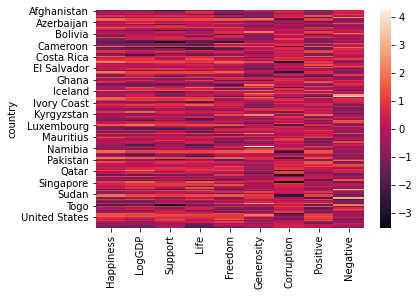

In [3]:
import seaborn as sns
sns.heatmap(X_scaled)

### Step 3.

The countries in the heatmap you have just created are ordered alphabetically, leading to what looks like a more or less random pattern of indicator values as you scan down the heatmap.  The point of clustering is to pull out subgroups (clusters) that share similar indicator profiles.

The first clustering algorithm we will examine is KMeans (sometimes written as k-means or K-means), which is described in more detail in the [scikit-learn documentation](https://scikit-learn.org/stable/modules/clustering.html#k-means).  With k-means, one specifies in advance how many clusters they would like to group the data into, and this value is the number k (or K), hence the name of the method.  Sometimes one needs to experiment with different values of k to see what best reflects the nature of the data.  k-means works by finding a set of "centroid" points at the center of each cluster, so that every data point within a cluster is closer to the center of its own cluster than to the centroid of a different cluster.

In a hypothetical dataset with N data points, a "perfect but meaningless" clustering of the data would involve making as many clusters as there are data points, that is, setting k = N.  In such a scenario, every data point (e.g., every country in our dataset) would be in its own cluster, perfectly identical to itself, but meaningless in terms of revealing structure and patterns in the data.  In the opposite limit, k = 1, all the data points would be in the same cluster, which leaves us no better than where we started.  The point of clustering is to find a number of clusters k (somewhere between 1 and N) that captures substructure within the data.

In the case of our WHR data, a useful guess for k might reflect the number of different regions that are contained in the ```df2``` dataframe.  You might recall that in the previous classification exercise, we built a classifier in order to try to predict the world region that a country is associated with based on its WHR indicators.  In this exercise, we want to cluster countries just based on the WHR indicators, and might be interested in how well the clustering reflects the region data.  Thus, a useful place to start here is to set k to be the number of unique regions contained in the ```df2``` dataframe.

Let's first figure out how many clusters we want to find.

In the code cell below:

* compute the number of unique region labels in ```df2``` (hint: look for information in pandas about the ```nunique``` method), and assign this value to the variable ```k```
* print the value of ```k```, so that you know how many clusters you are looking for

## Graded Cell

This cell is worth 20% of the grade for this assignment.

In [4]:
# YOUR CODE HERE
k=df2.nunique()['region']

## Self-Check

Run the cell below to test the correctness of your code above before submitting for grading.


In [5]:
# Run this self-test cell to check your code; do not add code or delete code in this cell
from jn import testK

try:
    print(testK(df2, k))    
except Exception as e:
    print("Error!\n" + str(e))

Correct!


### Step 4.

Having identified the number of clusters we want to look for, let's continue with k-means.  (If you did not succeed above in finding the number of unique regions, set k = 10.)

In the code cell below:

* import the ```KMeans``` class from the ```sklearn.cluster``` submodule
* initialize a `KMeans` cluster object to identify ```k``` clusters, and assign this object to the variable ```kcluster``` &mdash; the relevant option to pass to ```KMeans``` is called ```n_clusters```
* call the ```fit``` method on ```kcluster``` so that you can fit the data in the ```X_scaled``` dataframe

In [15]:
from sklearn.cluster import KMeans
kcluster=KMeans(n_clusters=k)
kcluster.fit(X_scaled)
kcluster.labels_

array([7, 8, 1, 8, 4, 8, 5, 5, 1, 3, 6, 1, 5, 4, 7, 9, 3, 8, 2, 4, 1, 6,
       7, 9, 6, 5, 7, 7, 3, 4, 6, 6, 4, 1, 3, 4, 0, 3, 3, 8, 3, 1, 6, 0,
       4, 8, 8, 5, 6, 1, 4, 7, 7, 4, 0, 1, 5, 6, 9, 8, 8, 5, 3, 3, 6, 4,
       4, 3, 4, 2, 2, 4, 2, 9, 1, 8, 2, 7, 3, 1, 0, 8, 2, 6, 4, 2, 5, 2,
       4, 4, 1, 2, 8, 1, 6, 9, 2, 6, 5, 0, 3, 6, 2, 0, 7, 8, 4, 4, 3, 3,
       4, 3, 0, 1, 1, 6, 4, 2, 8, 7, 0, 1, 3, 2, 1, 7, 3, 9, 2, 0, 0, 8,
       4, 6, 2, 9, 7, 4, 8, 8, 6, 1, 0, 5, 5, 4, 4, 4, 4, 8, 6, 2],
      dtype=int32)

In [7]:
#from sklearn.cluster import KMeans
#kcluster1=KMeans(n_clusters=5)
#kcluster1.fit(X_scaled)
#df2_clustered1=df2.copy()
#df2_clustered1['klabel']=kcluster1.labels_
#X_scaled_clustered1=X_scaled.copy()
#df2_clustered1.head()

,Happiness,Positive,Negative,LogGDP,Support,Life,Freedom,Generosity,Corruption,region,klabel
country,,,,,,,,,,,
Afghanistan,3.806614,0.580873,0.301283,7.419697,0.517146,50.838271,0.544895,0.118428,0.826794,South Asia,4
Albania,4.988791,0.642628,0.303256,9.247059,0.723204,68.027213,0.626155,-0.105019,0.859691,Central and Eastern Europe,0
Algeria,5.555004,0.616524,0.265460,9.501728,0.804633,64.984461,0.536398,-0.208236,0.661478,Middle East and North Africa,0
Angola,4.420299,0.613339,0.351173,8.713935,0.737973,51.729801,0.455957,-0.077940,0.867018,Sub-Saharan Africa,4
Argentina,6.406131,0.840998,0.273187,9.826051,0.906080,66.764205,0.753122,-0.154544,0.844038,Latin America and Caribbean,3


### Step 5.

The output from the code cell above, if entered and run correctly, should note some further information about the KMeans clusterer that you have created and fit to the data.  There are various other options that can in principle be specified in constructing the object; the only option we specified above was ```n_clusters```, and used the default values of everything else.  

You will notice an entry for ```n_init=10```.  This refers to the fact that the k-means algorithm starts from a initial guess for the centroid locations, and runs the algorithm repeatedly with different starting guesses (n_init times), choosing the best clustering from the group.

Once the KMeans clusterer has fit the data (as you have done above), it contains various data attributes that we can query. One of these attributes is the ```labels_``` object, which is an array of integers that assigns a cluster label to each entry in the dataset.  For our WHR data, therefore, the ```labels_``` object describes, in the same order in which the data appears in our ```X_scaled``` dataframe, which cluster each country belongs to.

In the code cell below, print the value of ```kcluster.labels_``` and examine the output.

In [16]:
kcluster.labels_

array([7, 8, 1, 8, 4, 8, 5, 5, 1, 3, 6, 1, 5, 4, 7, 9, 3, 8, 2, 4, 1, 6,
       7, 9, 6, 5, 7, 7, 3, 4, 6, 6, 4, 1, 3, 4, 0, 3, 3, 8, 3, 1, 6, 0,
       4, 8, 8, 5, 6, 1, 4, 7, 7, 4, 0, 1, 5, 6, 9, 8, 8, 5, 3, 3, 6, 4,
       4, 3, 4, 2, 2, 4, 2, 9, 1, 8, 2, 7, 3, 1, 0, 8, 2, 6, 4, 2, 5, 2,
       4, 4, 1, 2, 8, 1, 6, 9, 2, 6, 5, 0, 3, 6, 2, 0, 7, 8, 4, 4, 3, 3,
       4, 3, 0, 1, 1, 6, 4, 2, 8, 7, 0, 1, 3, 2, 1, 7, 3, 9, 2, 0, 0, 8,
       4, 6, 2, 9, 7, 4, 8, 8, 6, 1, 0, 5, 5, 4, 4, 4, 4, 8, 6, 2],
      dtype=int32)

### Step 6.

The actual numbers associated with the cluster labels are meaningless, and will change each time you run the clustering algorithm.  (By this we mean that we could permute the labels of all the clusters, and the underlying clustering of the data would remain unchanged.)  What is meaningful, however, is which countries *share* the same cluster label, since that means they are assigned to the same cluster (regardless of what cluster label number that is).  Since the cluster labels printed above contain no information about the countries they correspond to, it is useful to combine the cluster labels with the dataframes that they originated from.  We'll do that by creating a copy of both the ```df2``` and ```X_scaled``` dataframes, and adding information about the cluster labels.

In the code cell below:

* make a copy of the ```df2``` dataframe using its ```copy``` method and assign the result to a new variable named ```df2_clustered```
* add a new column named 'klabel' to ```df2_clustered``` so that it is filled with the data in ```kcluster.labels_``` (hint: you can just assign the labels to a new column called ```df2_clustered['klabel']```)
* make a copy of the ```X_scaled``` dataframe and assign it to ```X_scaled_clustered```
* add a new column named 'klabel' to ```X_scaled_clustered``` so that it is filled with the data in ```kcluster.labels_```

Once you've done so, examine the new ```df2_clustered``` dataframe.  You should see the 'klabel' column now &mdash; any two countries with the same label have been assigned to the same cluster.

In [17]:
df2_clustered=df2.copy()
df2_clustered['klabel']=kcluster.labels_
X_scaled_clustered=X_scaled.copy()
df2_clustered.head()

,Happiness,Positive,Negative,LogGDP,Support,Life,Freedom,Generosity,Corruption,region,klabel
country,,,,,,,,,,,
Afghanistan,3.806614,0.580873,0.301283,7.419697,0.517146,50.838271,0.544895,0.118428,0.826794,South Asia,7
Albania,4.988791,0.642628,0.303256,9.247059,0.723204,68.027213,0.626155,-0.105019,0.859691,Central and Eastern Europe,8
Algeria,5.555004,0.616524,0.265460,9.501728,0.804633,64.984461,0.536398,-0.208236,0.661478,Middle East and North Africa,1
Angola,4.420299,0.613339,0.351173,8.713935,0.737973,51.729801,0.455957,-0.077940,0.867018,Sub-Saharan Africa,8
Argentina,6.406131,0.840998,0.273187,9.826051,0.906080,66.764205,0.753122,-0.154544,0.844038,Latin America and Caribbean,4


### Step 7.

Recall that each cluster is approximately defined by its centroid, which we can think of as a typical or average indicator profile for that cluster.  Our data points actually live in a 9-dimensional space (9 elements in ```key_vars```), so it's a little hard to visualize the data.  But if we want to see what each of the clusters approximately "looks like," we can just plot the coordinates of the cluster centroids, which are stored in the attribute ```kcluster.cluster_centers_```.

Execute the code cell below to make a plot of the cluster centers and their associated label numbers.  Note that the cluster centers are all distinct from one another, although clusters are somewhat closer to each other.  This might be indicative of the fact that k=10 might be too many clusters to properly represent this dataset; if k were reduced, some of the nearby clusters would probably collapse into a larger metacluster reflecting their approximately common profile.  We'll just examine the k=10 case in this exercise, but if you're interested in investigating further on your own, you could try some other values of k to see how the results change.

Feel free to modify the code in the cell below if you want to tweak the plot, or to understand what each of the commands there is doing.

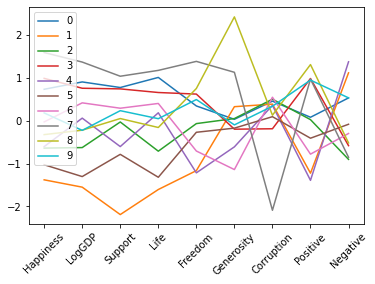

In [10]:
for i in range(10):
    plt.plot(kcluster.cluster_centers_[i], label=i)
plt.xticks(range(9), key_vars, rotation=45)
plt.legend()

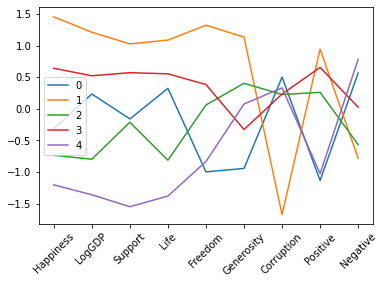

In [11]:
for i in range(5):
    plt.plot(kcluster1.cluster_centers_[i], label=i)
plt.xticks(range(9), key_vars, rotation=45)
plt.legend()

### Step 8.

In the plot above, each line represents the centroid of one cluster (for clusters labeled 0 through 9).  For each cluster, there is a group of countries whose indicator profiles lie near to these centroids.

First examine, and then execute, the code cell below.  

The code cell below defines a function called ```plot_cluster_and_centroid```, which takes as input an integer cluster label, and plots all country profiles within the cluster (in different colors) along with the centroid profile (plotted with a black dashed line and black point markers).

After the function definition, the function is called to produce a plot for cluster label 0.

Once you've examined the plot for cluster 0, modify the cluster label being passed to the function in order to view each of the other 9 clusters that have been produced (10 clusters in all, since we set k = 10).  In other words, modify the input to the function one at a time, and re-execute the code cell, or &mdash; if you prefer &mdash; open up additional code cells below to plot each of the clusters in turn. At present, the plot turns off the legend indicating the names of the countries in each cluster (```legend=False```), since the legend clutters the figure for large clusters and is difficult to reposition.  But if you're curious, try turning the legend back on to see the contents of each cluster.

Take some time to examine these plots to understand what they are conveying.  Some clusters represents countries that might have greater Happiness and lower Corruption, for example, whereas others might represent different combinations of attributes.

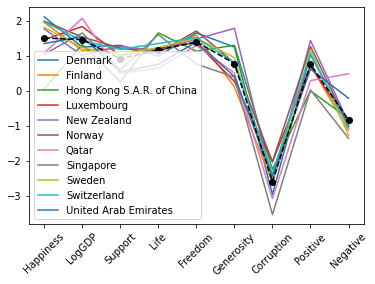

In [25]:
def plot_cluster_and_centroid(label):
    X_scaled_clustered[df2_clustered.klabel==label][key_vars].T.plot(legend=label)
    plt.plot(kcluster.cluster_centers_[label], 'ko--')
    plt.xticks(range(9), key_vars, rotation=45)
    plt.legend()

plot_cluster_and_centroid(0)

### Step 9.

We might be interested in how the results produced by k-means clustering relate to the region information that is stored in the ```df2_clustered``` dataframe.  As we discussed above, the cluster labels themselves are meaningless, but we can easily examine how each cluster label (klabel) aligns with different world regions.  For example, we might want to know how many countries from each region are associated with cluster number 0, cluster number 1, etc.

In the code cell below, write an expression to group the data in ```df2_clustered``` by both 'klabel' and 'region', and compute the size of each (klabel, region) pair.  You can do this in one line using the ```groupby``` method on dataframes that we have studied previously, along with the ```size()``` method that is applied to each group produced by the groupby operation.  An operation of this sort will produce a new dataframe with a two-level MultiIndex (i.e., each row described by its ('klabel', 'region') pair), with the corresponding column indicating how many countries are associated with that pair.

## Graded Cell

This cell is worth 40% of the grade for this assignment. <i>Note: a self-check will not accompany this assignment.</i><br>
Your output should look similar to this (your results may be different): <br><img src="clusteringStep9.png" width=400 height=400  align="left"/>

In [31]:
# YOUR CODE HERE
df2_clustered.groupby(['klabel','region']).size()

klabel  region                            
0       East Asia                              1
        Middle East and North Africa           2
        North America and ANZ                  1
        Southeast Asia                         1
        Western Europe                         6
1       Central and Eastern Europe             8
        Commonwealth of Independent States     5
        East Asia                              1
        Middle East and North Africa           2
        Western Europe                         1
2       Central and Eastern Europe             1
        Commonwealth of Independent States     1
        East Asia                              1
        Sub-Saharan Africa                    13
3       Central and Eastern Europe             1
        Latin America and Caribbean            7
        Middle East and North Africa           4
        Southeast Asia                         1
        Western Europe                         4
4       Central and Easter

### Step 10.

The k-means algorithm is just one of many clustering algorithms supported by sklearn.  A colorful overview of different clustering methods is provided in the [sklearn documentation](https://scikit-learn.org/stable/modules/clustering.html).

Another widely used clustering method is known as [Hierarchical clustering](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering), some variants of which are known as agglomerative clustering.  This method takes a slightly more nuanced approach to the process of clustering.  Whereas k-means clustering specifies a fixed number of clusters to group data into, hierarchical clustering develops a "hierarchy" of clustering relationships where data points are grouped more closely together if they are more similar to each other.  It's somewhat like the way that ancestry works.  If someone were to ask you how many people you are related to, you might reply that it depends on how far back they want to go in time to define "relatedness." Presumably we are all related to each other (however remotely) if we go back far enough in time to a common evolutionary ancestor, but that fact might not be so useful in defining "relatedness" or "clusters" of people.  Nonetheless, hierarchical clustering does provide insight into these hierarchical relationships among clusters, and lends itself to useful visualization techniques that reveal those relationships.

The sklearn package provides objects and methods for `AgglomerativeClustering` that operate similarly to the way that the KMeans object worked in the exercises above, by creating a clustering object and then fitting it to the dataset of interest.  If you're interested, you can investigate this further below by following along with the sklearn documentation.  Unfortunately, sklearn does not provide great support for plotting the results of hierarchical clustering, generally referred to as dendograms.  There is some code showing a [simple example](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html).

Instead, we will work with seaborn (sns), which provides a useful function called ```clustermap``` that performs a hierarchical clustering and displays the results.  The clustermap function is described in the [seaborn documentation](https://seaborn.pydata.org/generated/seaborn.clustermap.html#seaborn.clustermap).  The function actually uses a version of the clustering algorithm that is included as part of [scipy](http://scipy.org), a Python package that provides a wealth of useful tools for scientific computing, but which we have not emphasized in this course material.

In the code cell below, enter and execute a call to ```sns.clustermap``` to operate on the ```X_scaled``` dataframe, providing the following additional options:

* ```method = 'average'```
* ```metric = 'euclidean'```
* ```figsize = (15,40)```

Note that you are instructed to cluster the data in ```X_scaled```.  You wouldn't want to cluster the data in the augmented dataframe that you created above (```X_scaled_clustered```), because that contains additional information about the k-means cluster labels that you don't want to include here.

Your code should construct and display a figure that looks a bit like the heatmap that we created earlier in this exercise, but with some differences.  As was discussed above, if the figure is in a sub-window that you'd like to expand, you can click on the panel to the left of the figure to do so.

After you have produced the figure, proceed to the material below the figure to read further about what is plotted.

## Graded Cell

This cell is worth 40% of the grade for this assignment. <i>Note: a self-check will not accompany this assignment.</i><br>
Your plot should look like this: <br><img src="clusteringStep10.png" width=200 height=400  align="left"/>

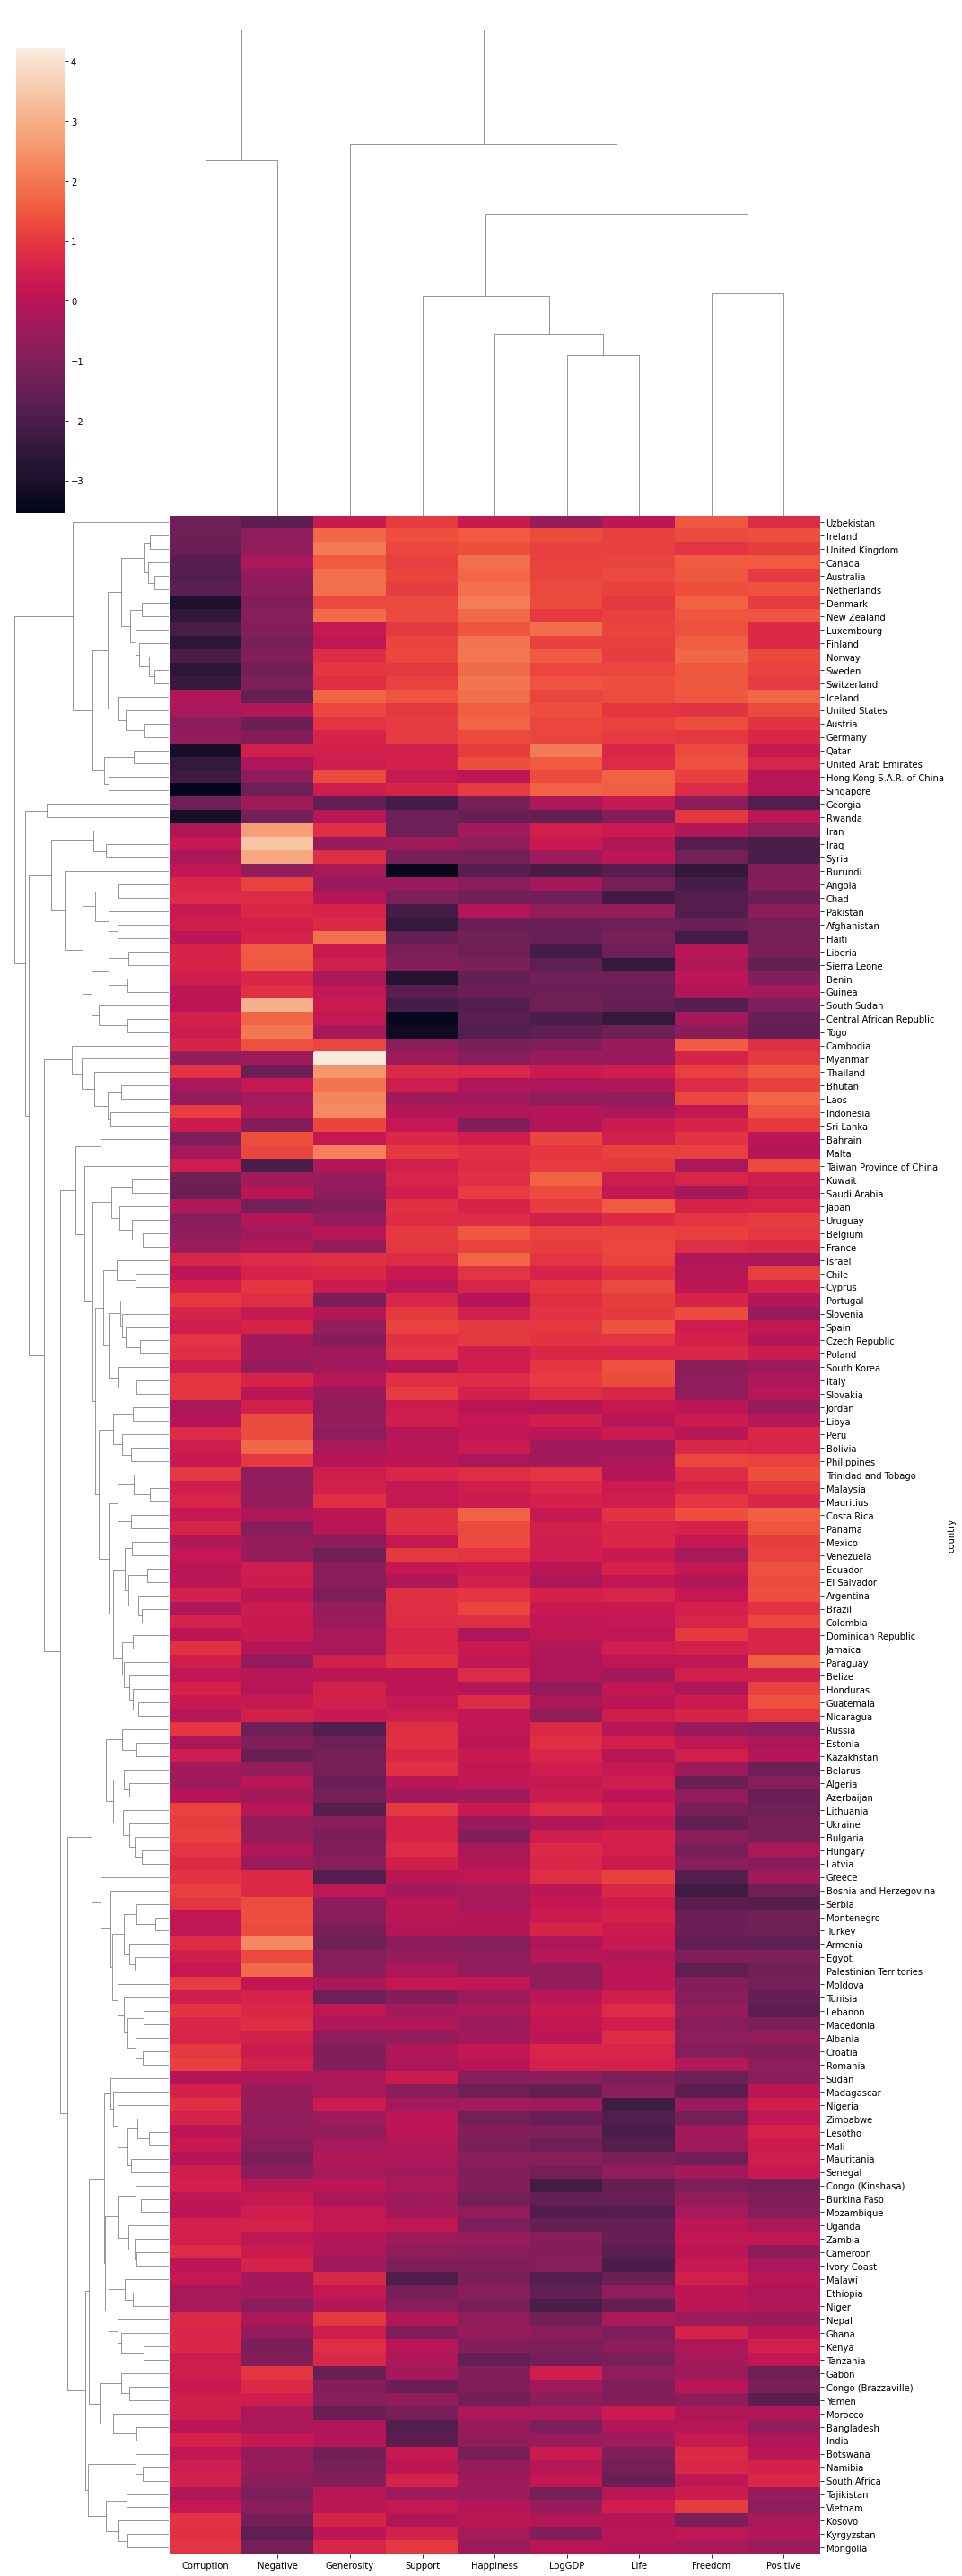

In [32]:
# YOUR CODE HERE
import seaborn as sns
sns.clustermap(X_scaled,method = 'average', metric = 'euclidean', figsize = (15,40))

## Step 11.

There are several things you should notice about the plot produced by the clustermap.  First, whereas our original heatmap ordered the countries alphabetically, with a more or less random pattern of indicator values as a result, this clustermap has reordered the rows to reflect the clustering.

You should also notice a tree-like structure running along the left-hand side of the heatmap.  This tree, also known as a dendogram, is what is providing information about the clustering.  It is a tree, because it starts from a broad trunk at the far left of the dendogram down to finer and finer sub-branches and finally down to individual "leaves" that represent individual countries.  The clustering algorithm works from the bottom up: It finds several pairs of countries that are highly similar within each pair (smallest euclidean distance between them, in this version of the analysis), and then finds other countries that are similar to each pair.  Thus the algorithm grows clusters by accreting (or agglomerating) onto groupings that have already been identified.  The similarity between two countries in the tree is reflected by how far you need to go "up" the tree from one country and then back "down" to the other one.  If you go far enough up the tree, all countries are similar enough to each other to be grouped in one big cluster, similar to how all people are related to one another if we go back far enough in time.  Two countries that are near each other vertically in the reordered heatmap tend to be more similar to each other, but that is not strictly the case.  You should notice that at particular parts of the dendogram different branches end up getting placed nearby each other in this 2D representation, but their distance from each other up and back down the tree could be very far.

There are some other things to notice in this plot.  

First, despite the fact that nearby ordering in the heatmap does not always reflect close similarity in the tree, you should be able to discern some clustering visually in the reordered heatmap, that is, groups of countries with similar WHR indicator profiles.  If you see a group of countries with similar indicator profiles (similar patterns of colors in the heatmap), you should be able to identify the sub-tree on the left that group is associated with.

Second, you should notice that the columns of the dataset have also been clustered, with their own dendogram running along the top.  This is indicative of the fact that some groups of indicator variables are more closely associated among themselves, such as 'LogGDP' and 'Life' (life expectancy) which are clustered more closely together.  Clustering along both axes of a dataset is known as "biclustering", and is turned on by default in ```clustermap```.  If you want to cluster only along one axis, you could modify either the `row_cluster` or `col_cluster` options to the function.

Finally, we have chosen just one set of criteria to carry out this clustering (```method='average'``` and ```metric='euclidean'```).  In order to identify groups of similar items in a dataset, we need to specify mathematically what we mean by "similar."  In this case, we have defined the similarity of two data points based on their euclidean distance from each other (such that two identical items would be separated by zero distance).  But we could have chosen some other criterion instead, such as the correlation between two data points.  In addition, in hierarchical clustering, one needs to specify not only how similar two *data points* are, but also to specify how similar two *clusters* are (since it is building up clusters of clusters).  This is what the `method` parameter is about (or more specifically, what is called the "linkage method").  The similarity between two clusters might be based on how similar their two closest items are, or their two most distant items, or the average distance between all pairs of points in each cluster.

If you're interested, you can consult the documentation for clustermap and experiment with some different options to explore the effect of different clustering metrics and methods.  There is no one right answer, but generally you'd like to find clustering results that exhibit some degree of robustness to variations in these sorts of options.

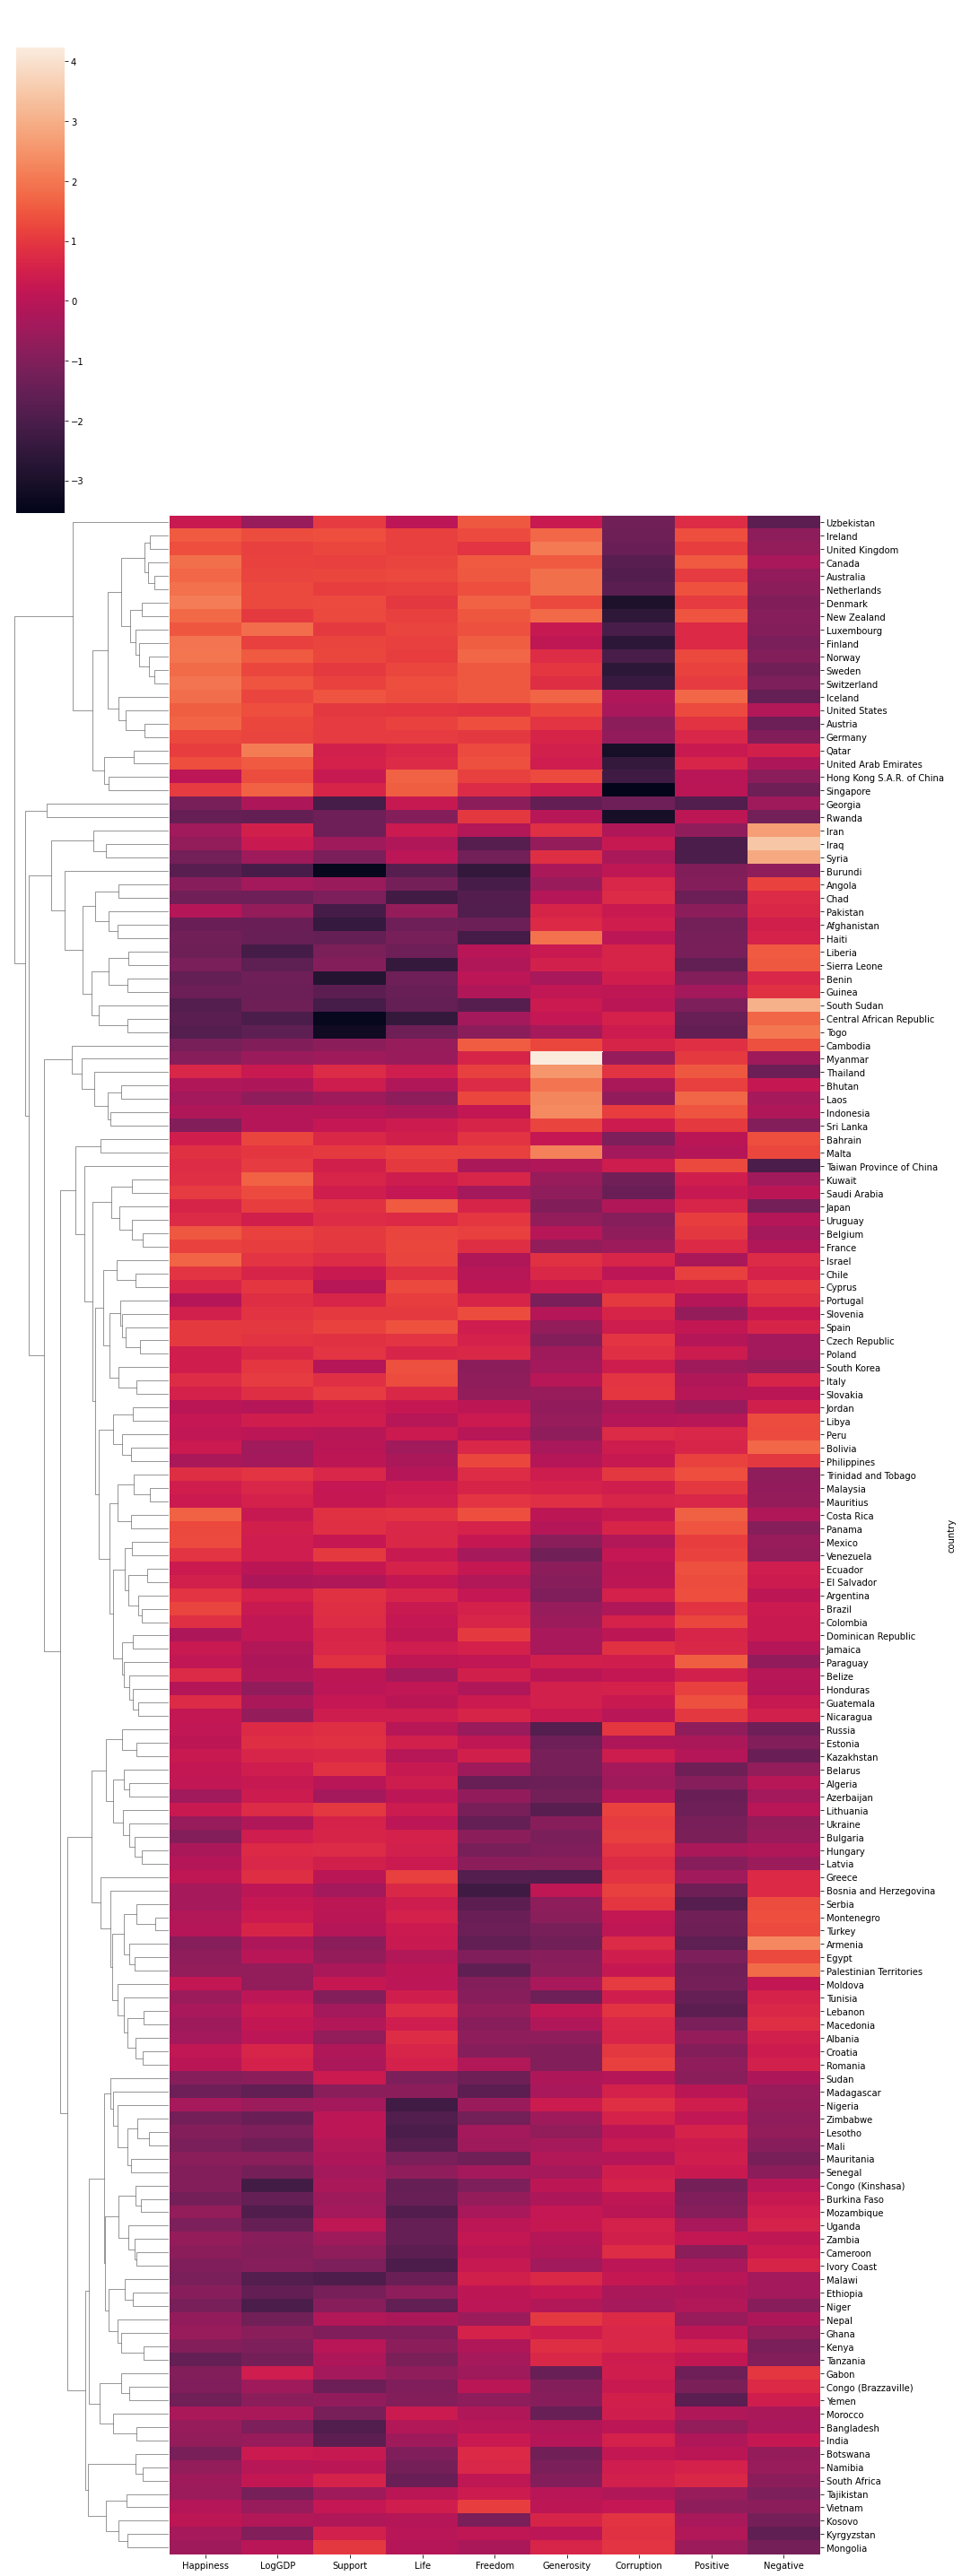

In [36]:
import seaborn as sns
sns.clustermap(X_scaled,method = 'average', metric = 'euclidean', col_cluster=False, figsize = (15,40))

### Step 12.

Congratulations!  You've worked through some interesting examples in using clustering to identify substructure and patterns in datasets, a key element in the suite of unsupervised machine learning techniques.  Feel free to explore these datasets some more to improve your mastery of machine learning methods and the scikit-learn package.